In [94]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

edges = pd.read_csv(r"../data/edges_updated_reversed.csv", sep=' ') #load the edges
edges_array = np.array(edges.loc[:, ['Source', 'Target']]) #convert it to np.array

G = nx.DiGraph() #empty DiGraph
G.add_edges_from(edges_array)

doSingletonReduction = True
doVisualizeSingletonReduction = True
doVisualization = True

if not doSingletonReduction:
    doVisualizeSingletonReduction = False

print(len(G.nodes()))

26234


In [95]:
# > Initialize layout of nodes (only have to run this only once, this can take a while)
if doVisualization:
    print("Calculating node layout and positions...")
    pos = nx.spring_layout(G, seed=8020, gravity=0.75)
    # pos = nx.forceatlas2_layout(G, seed=6969420, gravity=0.5, scaling_ratio=4.0, max_iter=50)
    print("Done!")

Calculating node layout and positions...
Done!


In [92]:
# Init nodes
# Need to run first block of code in order to initialize the singleton values in their parent nodes
nx.set_node_attributes(G, 0, "s_singletons")
nx.set_node_attributes(G, 0, "i_singletons")
nx.set_node_attributes(G, 0, "r_singletons")

singletons = G.out_degree
singletons = [x[0] for x in singletons if x[1] == 0]
singletons = [x for x in singletons if G.in_degree(x) == 1]

non_singletons = [x for x in list(G.nodes) if not x in singletons]

for node in non_singletons:
    adj = G.neighbors(node)
    G.nodes[node]['s_singletons'] = len([x for x in adj if x in singletons])

print(len(G.nodes()))

# > Remove nodes that are singletons
G.remove_nodes_from(singletons)
print(len(G.nodes()))

# > Remove nodes that don't have singletons
# not_have_singletons = [x[0] for x in list(G.nodes.data('s_singletons')) if x[1] == 0]
# have_singletons = [x[0] for x in list(G.nodes.data('s_singletons')) if x[1] == 1]
# G.remove_nodes_from(not_have_singletons)
# print(len(G.nodes()))

nodes_outdeg_sorted = sorted(list(G.out_degree), key=lambda x:x[1], reverse=True)


26234
19616


Number of nodes:  19616
Drawing network edges...


KeyError: 3943

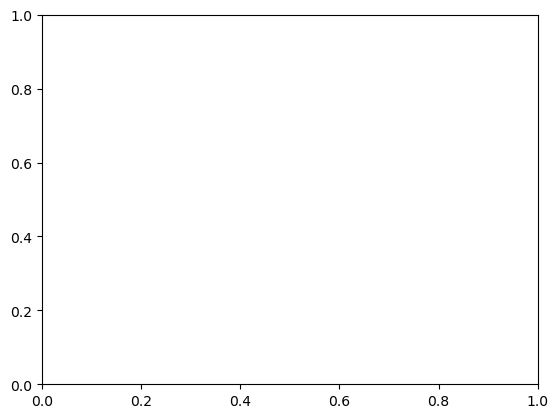

In [93]:
# > Initialize model
print("Number of nodes: ", len(G.nodes()))

nx.set_node_attributes(G, 0, "state")
"""
When state = 0, a node is susceptible.
When state = 1, a node is infected.
When state = 2, a node is recovered/removed.
"""

# init_infected = np.random.choice(G.nodes, 1)[0]
# init_infected = np.random.choice(nodes_outdeg_sorted, 1)[0]
init_infected = 9

# > Initially infect 1 node
G.nodes[init_infected]['state'] = 1

# > Hyperparameters
max_steps = 100
infection_probability = 0.99
recover_probability = 0.5

# > Drawing parameters
if doVisualization:
    options = {"node_size": 20}
    init_susceptible_color = np.array([0,1,0,0.5])
    susceptible_color = np.array([0,1,0,1])
    infected_color = np.array([1,0,0,1])
    removed_color = np.array([0,0,1,1])

    print("Drawing network edges...")
    nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.25)

    nx.draw_networkx_nodes(G, pos, nodelist=[x[0] for x in G.nodes.data('state') if x[1] == 0], alpha=0.45, node_color=[init_susceptible_color], **options, edgecolors=[susceptible_color])
    nx.draw_networkx_nodes(G, pos, nodelist=[x[0] for x in G.nodes.data('state') if x[1] == 1], node_color=[infected_color], **options, edgecolors=[susceptible_color])

    # nx.draw_networkx_labels(G, pos=pos, font_size=6)
    print("Done!")

    plt.axis("off")
    plt.tight_layout()
    print("Saving graph_0.png...")
    plt.savefig("graphs/graph_0.png", format="PNG")
    print("Done!")
    # plt.show()

# > Run model
print("Running model...")
def get_singleton_edgecolor(node_num):
    x = G.nodes[node_num]
    singleton_sum = x['s_singletons'] + x['i_singletons'] + x['r_singletons']
    if singleton_sum == 0:
        match x['state']:
            case 0:
                temp_color = susceptible_color
            case 1:
                temp_color = infected_color
            case 2:
                temp_color = removed_color
    else:
        temp_color = x['s_singletons']*susceptible_color + x['i_singletons']*infected_color + x['r_singletons']*removed_color
        temp_color = temp_color/singleton_sum
    return temp_color

infected_list = set()
for i in G.nodes.data('state'):
    if i[1] == 1:
        infected_list.add(i[0])
has_infected_singletons = set()

# Run model
for step in range(max_steps):
    infected_singletons = sum(x[1] for x in G.nodes.data('i_singletons'))
    infected_non_singletons = len(infected_list)

    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Step: {step}")
    print(f"Infected left: {infected_non_singletons + infected_singletons}")
    print(f"> Non-singletons infected: {infected_non_singletons}")
    print(f"> Singletons infected: {infected_singletons}")

    # Early Stopping
    if len(infected_list) == 0 and sum(x[1] for x in G.nodes.data('i_singletons')) == 0:
        break

    # >>> Infection and recovery
    # > Singleton recovery
    print("Recovering singletons...")
    temp_infsng_list = list(has_infected_singletons)
    for i in temp_infsng_list:
        inf_sng = G.nodes[i]['i_singletons']
        if not inf_sng == 0:
            temp = np.random.binomial(n=inf_sng, p=recover_probability)
            G.nodes[i]['i_singletons'] -= temp
            G.nodes[i]['r_singletons'] += temp

            if doVisualization:
                match G.nodes[i]['state']:
                    case 0:
                        raise Exception("the hell")
                    case 1:
                        result_color = infected_color
                    case 2: 
                        result_color = removed_color
                
                nx.draw_networkx_nodes(G, pos, nodelist=[i], node_color=result_color, **options, edgecolors=get_singleton_edgecolor(i))
        else:
            has_infected_singletons.remove(i)

    print("Infecting singletons and neighbors + Recovering infected nodes...")
    temp_inf_list = list(infected_list)
    for i in temp_inf_list:
        # > Infect neighbors
        adj = G.neighbors(i)
        for j in adj:
            if G.nodes[j]['state'] == 0 and np.random.sample() < infection_probability:
                infected_list.add(j)
                G.nodes[j]['state'] = 1
                if doVisualization:
                    nx.draw_networkx_nodes(G, pos, nodelist=[j], node_color=infected_color, **options, edgecolors=get_singleton_edgecolor(j))

        # > Infect singletons
        # print(G.nodes[i]['s_singletons'])
        temp = np.random.binomial(n=G.nodes[i]['s_singletons'], p=infection_probability)
        if temp > 0:
            has_infected_singletons.add(i)
        G.nodes[i]['s_singletons'] -= temp
        G.nodes[i]['i_singletons'] += temp

        # > Recovery
        if np.random.sample() < recover_probability:
            infected_list.remove(i)
            G.nodes[i]['state'] = 2

        if doVisualization:
            match G.nodes[i]['state']:
                case 0:
                    raise Exception("the hell")
                case 1:
                    result_color = infected_color
                case 2: 
                    result_color = removed_color
            nx.draw_networkx_nodes(G, pos, nodelist=[i], node_color=result_color, **options, edgecolors=get_singleton_edgecolor(i))

    # > Export graphs
    if doVisualization:
        plt.axis("off")
        plt.tight_layout()
        print(f"Saving graph_{step+1}.png...")
        plt.savefig(f"graphs/graph_{step+1}.png", format="PNG")
        print(f"Saved graph!")

In [59]:
# > Clear all pngs in graphs folder
for filename in os.listdir("graphs"):
   file_path = os.path.join("graphs", filename)
   if os.path.isfile(file_path):
      os.remove(file_path)

In [70]:
# > Export images in graphs folder to a gif
from PIL import Image

# List of image file paths
images = sorted(os.listdir("graphs"), key=lambda x:int(x[x.find('_')+1:x.find('.')]))
# print(images)

# Open images and store them in a list
frames = [Image.open(f"graphs/{image}") for image in images]

# Save frames as an animated GIF
frames[0].save(
    'simple_sir_model.gif',
    save_all=True,
    append_images=frames[1:],
    duration=300,
    loop=0
)
